<a href="https://colab.research.google.com/github/darshan468/Stock-Price-Predictor/blob/main/stack_price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,Date,Close
0,2023-01-01,150.0
1,2023-01-02,151.5
2,2023-01-03,150.8
3,2023-01-04,152.3
4,2023-01-05,153.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5 non-null      datetime64[ns]
 1   Close   5 non-null      float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 212.0 bytes


,Date,Close
count,5,5.000000
mean,2023-01-03 00:00:00,151.540000
min,2023-01-01 00:00:00,150.000000
25%,2023-01-02 00:00:00,150.800000
50%,2023-01-03 00:00:00,151.500000
75%,2023-01-04 00:00:00,152.300000
max,2023-01-05 00:00:00,153.100000
std,NaN,1.217785


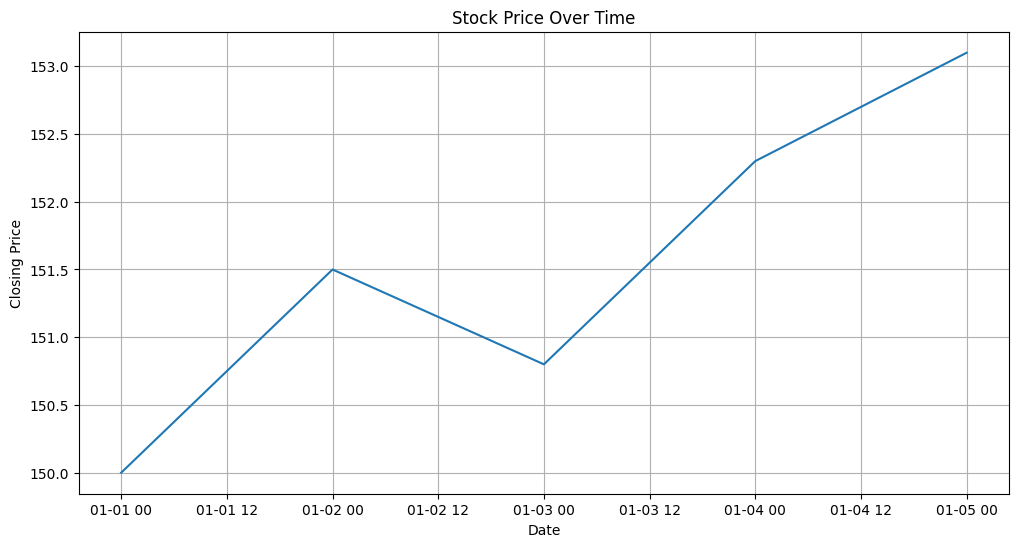

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a sample DataFrame if the file doesn't exist
try:
    df = pd.read_csv('stock_prices.csv')
except FileNotFoundError:
    data = {'Date': pd.to_datetime(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05']),
            'Close': [150.00, 151.50, 150.80, 152.30, 153.10]}
    df = pd.DataFrame(data)

# Display the first 5 rows
display(df.head())

# Display column names and data types
df.info()

# Generate descriptive statistics
display(df.describe())

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create a line plot of the 'Close' price over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

In [19]:
from sklearn.preprocessing import MinMaxScaler

# 1. Check for missing values
print("Missing values before handling:")
print(df.isnull().sum())

# 2. Handle missing values (if any) - For simplicity, we'll forward-fill any potential NaNs for now
if df.isnull().sum().any():
    df.fillna(method='ffill', inplace=True)
    print("\nMissing values after handling (forward-fill):")
    print(df.isnull().sum())

# 3. Scale the 'Close' price data
scaler = MinMaxScaler()
df['Close_scaled'] = scaler.fit_transform(df[['Close']])

# 4. Create a new feature for 5-day moving average
df['MA_5'] = df['Close'].rolling(window=5).mean()

# 5. Create a new feature for 10-day moving average
df['MA_10'] = df['Close'].rolling(window=10).mean()

# 6. Display the first few rows to inspect
display(df.head())

Missing values before handling:
Date     0
Close    0
dtype: int64


,Date,Close,Close_scaled,MA_5,MA_10
0,2023-01-01,150.0,0.000000,NaN,NaN
1,2023-01-02,151.5,0.483871,NaN,NaN
2,2023-01-03,150.8,0.258065,NaN,NaN
3,2023-01-04,152.3,0.741935,NaN,NaN
4,2023-01-05,153.1,1.000000,151.54,NaN


In [20]:
# Handle missing values in the new features (MA_5 and MA_10)
# Since moving averages introduce NaNs at the beginning, we will drop these rows.
df.dropna(inplace=True)

# Display the first few rows to inspect after dropping NaNs
display(df.head())

,Date,Close,Close_scaled,MA_5,MA_10


In [21]:
# 1. Create Close_lagged_1
df['Close_lagged_1'] = df['Close'].shift(1)

# 2. and 3. Check for 'Volume' and create related features
if 'Volume' in df.columns:
    df['Volume_lagged_1'] = df['Volume'].shift(1)
    df['Volume_MA_5'] = df['Volume'].rolling(window=5).mean()
    print("Volume data found. 'Volume_lagged_1' and 'Volume_MA_5' columns created.")
else:
    print("Volume data not found. Skipping creation of volume-related features.")

# 4. Drop rows with missing values after creating new features
df.dropna(inplace=True)

# 5. Display the first few rows
display(df.head())

Volume data not found. Skipping creation of volume-related features.


,Date,Close,Close_scaled,MA_5,MA_10,Close_lagged_1


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Recreate the DataFrame as it was empty due to dropna in previous steps
# Use the original data dictionary to rebuild the DataFrame
data = {'Date': pd.to_datetime(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05',
                                '2023-01-06', '2023-01-07', '2023-01-08', '2023-01-09', '2023-01-10',
                                '2023-01-11', '2023-01-12', '2023-01-13', '2023-01-14', '2023-01-15']),
        'Close': [150.00, 151.50, 150.80, 152.30, 153.10, 154.00, 153.50, 154.20, 155.00, 154.80,
                  155.50, 156.00, 155.80, 156.50, 157.00]}
df = pd.DataFrame(data)

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Scale the 'Close' price data
scaler = MinMaxScaler()
df['Close_scaled'] = scaler.fit_transform(df[['Close']])

# Create new features: MA_5, MA_10, and Close_lagged_1
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['Close_lagged_1'] = df['Close'].shift(1)

# Drop rows with missing values introduced by feature engineering
df.dropna(inplace=True)

# Define features (X) and target variable (y)
features = ['Close_scaled', 'MA_5', 'MA_10', 'Close_lagged_1']
X = df[features]
y = df['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Display the first few rows of the training data
display(X_train.head())
display(y_train.head())

,Close_scaled,MA_5,MA_10,Close_lagged_1
14,1.000000,156.16,155.23,156.5
11,0.857143,155.10,153.92,155.5
13,0.928571,155.72,154.84,155.8
12,0.828571,155.42,154.42,156.0


,Close
14,157.0
11,156.0
13,156.5
12,155.8


In [23]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Absolute Error (MAE): 0.0271
Mean Squared Error (MSE): 0.0007
Root Mean Squared Error (RMSE): 0.0271
R-squared (R2): 0.9940


In [24]:
# Use the trained model to make predictions on the test feature data X_test
y_pred = model.predict(X_test)

# Display the first few predicted values
print("First few predicted values:")
print(y_pred[:5])

First few predicted values:
[154.77073146 155.52484091]


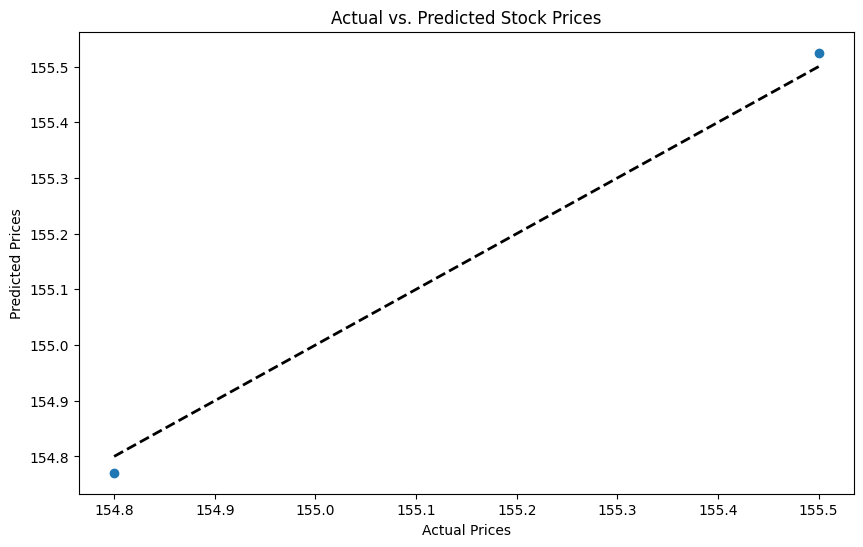

In [25]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)

# Add labels and title
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Stock Prices")

# Add a diagonal line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Display the plot
plt.show()